# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y SVM:**

Se selccionan las variables explicativas y la respuesta.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [3]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [5]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [7]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

## **4.1.1 SVM sin tecnicas de balanceo**

In [12]:
svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",          # kernel radial base (default)
        C=1.0,                 # parámetro de regularización
        gamma="scale",         # parámetro del kernel
        probability=True,     # SVC no usa predict_proba por defecto
        random_state=42
    ))
])

In [13]:
svm_pipeline.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', SVC(probability=True, random_state=42))])

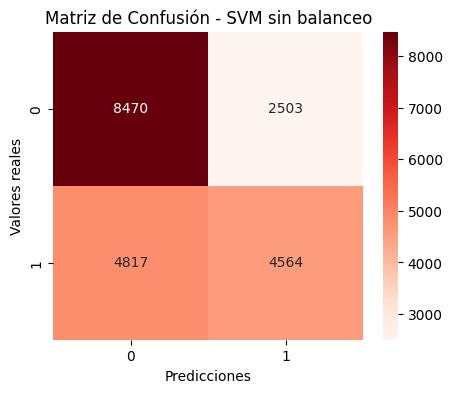

Modelo: SVM sin balanceo
Accuracy: 0.64
Precision: 0.646
Recall: 0.487
F1-score: 0.555
AUC: 0.692

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70     10973
           1       0.65      0.49      0.55      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



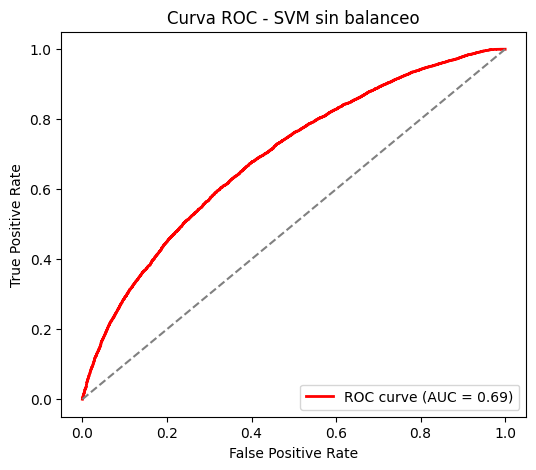

In [14]:
svm_normal = evaluar_modelo(svm_pipeline, X_test, y_test,nombre_modelo="SVM sin balanceo")

## **4.1.2 SVM con SMOTE**

In [15]:
svm_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])

In [16]:
svm_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

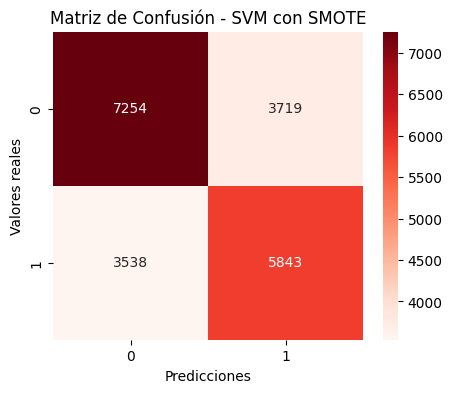

Modelo: SVM con SMOTE
Accuracy: 0.643
Precision: 0.611
Recall: 0.623
F1-score: 0.617
AUC: 0.693

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.66      0.67     10973
           1       0.61      0.62      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



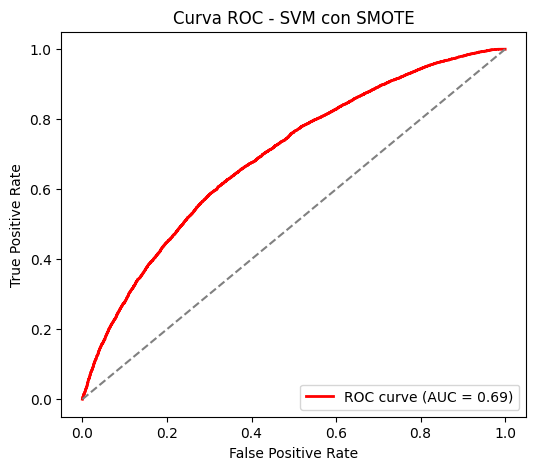

In [17]:
svm_smote = evaluar_modelo(svm_pipeline_smote, X_test, y_test, nombre_modelo="SVM con SMOTE")

## **4.1.3 SVM con ADASYN**

In [18]:

svm_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])


try:
    svm_pipeline_adasyn.fit(X_train, y_train)
    svm_adasyn = evaluar_modelo(svm_pipeline_adasyn, X_test, y_test, nombre_modelo="SVM con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    svm_adasyn = {"Modelo": "SVM con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [45]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

## **4.1.4 SVM con class_weight=’balanced’**


In [19]:
svm_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])


In [20]:
svm_pipeline_balanced.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

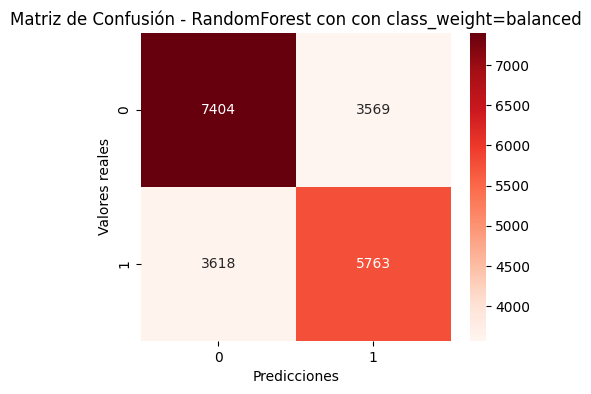

Modelo: RandomForest con con class_weight=balanced
Accuracy: 0.647
Precision: 0.618
Recall: 0.614
F1-score: 0.616
AUC: 0.694

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     10973
           1       0.62      0.61      0.62      9381

    accuracy                           0.65     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.65      0.65      0.65     20354



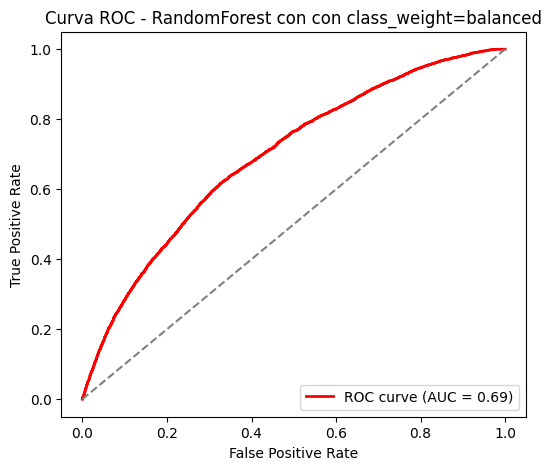

In [21]:
svm_balanced = evaluar_modelo(svm_pipeline_balanced, X_test, y_test, nombre_modelo="RandomForest con con class_weight=balanced")

## **4.1.5 Comparacion de resultados de tecnicas de balanceo para SVM**


In [22]:
tabla_resultados = pd.DataFrame([
    svm_normal,
    svm_smote,
    svm_balanced
])

In [23]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                                       Modelo  Accuracy  Precision    Recall  \
0                               SVM con SMOTE  0.643461   0.611065  0.622855   
1  RandomForest con con class_weight=balanced  0.646900   0.617553  0.614327   
2                            SVM sin balanceo  0.640366   0.645819  0.486515   

         F1       AUC  
0  0.616903  0.692940  
1  0.615935  0.694235  
2  0.554961  0.691903  
